# Laboratory 2.1: Graph Neural Networks (GNNs)

**Objectives:** 

- Implement a data-driven model based on graph neural networks (GNN) to estimate the pressures at the nodes of a water distribution system.
- Analyse the training performance of the implemented GNN.
- Evaluate the execution performance of the data-driven model to emulate nodal pressures.
- Transfer the developed data-driven model to a new case study.

**Completion requirements:**

By the end of this notebook, you should have:
- Implemented all code cells for:
  - defining a GNN-model. 
  - training the GNN-model
  - assesing the performance of the GNN-model.
  - transfering and assesing the GNN-model.
- Answered the analysis questions on each section. 

## 🔙 Background

Water utilities rely on hydrodynamic models to properly design and control water distribution systems (WDSs). These physically-based models, such as [EPANET](https://www.epa.gov/water-research/epanet), compute the state of the system, i.e., the flow rates and pressures at all the pipes and junctions, as illustrated in Figure 1. 

<center><figure>

  <img src="https://drive.google.com/uc?id=1D1yRrUTEbBRbEWNeyn1ibGJ23n8FQ90a" width=600/>
<figcaption>Figure 1. EPANET results in WDS in Fossolo, Italy. 

<sub><sup> Pressure and flows are presented with different color schemes. </sup></sub></figcaption>

</figure></center>

Hydrodynamic models provide valuable insight into the functioning of the system. However, the computational speed of these models is often insufficient for some applications in civil engineering such as optimisation of design or criticality assessment, especially in large search space problems. 

One alternative to address this issue is developing data-driven models. These models are trained using results calculated using the original model (EPANET, in this case) in multiple scenarios. The objective of the data-driven models is to estimate the output of the original model but in a shorter time.

## ⛔ Problem definition 

As part of a re-design of the Fossolo WDS, the water utility company has decided to use an optimisation approach. Aware that the established optimisation algorithms for designing water systems require a large number of scenarios, the company has decided to create a data-driven model to accelerate the process. 

From a graph machine learning perspective, this problem can be framed as a node regression. This is, given the network topology and input features at the nodes and/or edges, we want to use a GNN-model to infer the value of a variable at each node.

<center><figure>

  <img src="https://drive.google.com/uc?id=1HKOReaYv8KJMA0jkPfziSWbmDPIDc8Nw" width=600/>
<figcaption>Figure 2. Representation of water network as a graph. 

</figure></center>


As a consultant for the water utility, your task is to develop a GNN-based tool that can perform pressure estimation at the nodes. This system will process different configurations of network characteristics (e.g., pipe diameters, nodal demands, type of nodes), and estimate the pressure at each node of the system. 

This tool is developed in a _supervised learning_ manner by employing the scenarios datasets already prepared by the company. 


## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- NetworkX
- Scikit-learn
- Pytorch
- Pytorch geometric

In [27]:
import time
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import TAGConv
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.loader import DataLoader as pyg_DataLoader

## 📚 Database

The Fossolo water network has 37 nodes and 58 pipes. The network is represented as an undirected graph; this means that each pipe is represented as 2 edges, one incoming and one outgoing. In summary, each graph has 37 nodes and 116 edges.

For this WDS, we already have a database with 1000 scenarios. This database was created by generating multiple combinations of diameters at the pipes and water consumption at the nodes. 

The dataset was created using a Python package, based on EPANET, designed to simulate the behaviour of water distribution networks. Each scenario is represented as a [Data object](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) that contains edge features, node features, and the target feature. All of the features are already normalized based on a min-max scaling.

The diameter at the pipes is the only edge feature. The node features consist of water consumption, node_type (0 for junction and 1 for reservoirs), junction elevation, and reservoir elevation. 

*Run the following cell to load the datasets from the pickle files.*

In [28]:
with open('Training_dataset_WDS.p', 'rb') as handle:
    tra_dataset_pyg = pickle.load(handle)
with open('Validation_dataset_WDS.p', 'rb') as handle:
    val_dataset_pyg = pickle.load(handle)
with open('Test_dataset_WDS.p', 'rb') as handle:
    tst_dataset_pyg = pickle.load(handle)

In [29]:
print('Number of training examples:',   len(tra_dataset_pyg))
print('Number of validation examples:', len(val_dataset_pyg))
print('Number of test examples:',       len(tst_dataset_pyg))

Number of training examples: 750
Number of validation examples: 125
Number of test examples: 125


We can inspect the content of one example:

In [30]:
tra_dataset_pyg[0]

Data(x=[37, 4], edge_attr=[116, 1], edge_index=[2, 116], y=[37, 1])

Each example in the database contains the following information:
- **x:** Input node features with shape [Nodes, Node features]. This matrix is composed of 4 normalized variables for each node. Namely,
  - Normalized water consumption. Original values between 0 and 0.007 cubic meters per second.
  - Normalized junction elevation. Original values between 0 and 67.9 m.
  - Normalized reservoir elevation. Original values between 0 and 121 m.
  - One-hot encoding for type of node (1 for reservoir, 0 for junction)

- **edge_attr:** Input edge features with shape [Edges, Edge features]. This matrix is composed of 1 normalized variable for each pipe. Namely,
  - Normalized diameter. Original values between 0.025 and 0.4750.

- **edge_index:** Graph connectivity in COO format with shape [2, num_edges]

- **y:** Output node feature, i.e. target feature. Shape [Nodes, 1]. Original values between 0 and 59.56 mH2O.

## 💻 GNN training

**Instructions:**
Define a GNN model class, instantiate it, and train it.

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>
Imagine you are tasked with solving this problem using a GNN model.
*   What dimensions do the inputs and outputs have?
*   Which methods/architectures would you try first and why? (More than correctness, think of plausible components to test based on the problem description.)
*   What hyperparameters define the structure of the model?

Write your answers in the following cell

#### Answers:

1. The inputs should consist of both node features, which is [37,4], and edge features, which is [116,1]. The outputs should be of dimension [37,1], accounting for a predicted value for every node.
2. I would first try a GCNN, as it is the most basic graph networks introduced in the lectures, and is relatively easy to implement as we can construct the transfer matrix without difficulty.
3. The hyperparameters that define the structure of the model would be the number of layers, the hidden units in each layer, and the number $k$ for the $k-hop$ transition matrix.


---

### Model definition - Example

Below follows an example of a GNN model. You can use this code as a template for your own GNN model. 

In [31]:
class GNN_Example(nn.Module):
  """
    This class defines a PyTorch module that takes in a graph represented in the PyTorch Geometric Data format,
    and outputs a tensor of predictions for each node in the graph. The model consists of one or more TAGConv layers,
    which are a type of graph convolutional layer.

    Args:
        node_dim (int): The number of node inputs.
        edge_dim (int): The number of edge inputs.
        output_dim (int, optional): The number of outputs (default: 1).
        hidden_dim (int, optional): The number of hidden units in each GNN layer (default: 50).
        n_gnn_layers (int, optional): The number of GNN layers in the model (default: 1).
        K (int, optional): The number of hops in the neighbourhood for each GNN layer (default: 2).
        dropout_rate (float, optional): The dropout rate to be applied to the output of each GNN layer (default: 0).

    """
  def __init__(self, node_dim, edge_dim, output_dim=1, hidden_dim=50, n_gnn_layers=1, K=2, dropout_rate=0):
    super().__init__()
    self.node_dim = node_dim          
    self.edge_dim = edge_dim          
    self.output_dim = output_dim      
    self.hidden_dim = hidden_dim      
    self.n_gnn_layers = n_gnn_layers  
    self.K = K                        
    self.dropout_rate = dropout_rate
    
    self.convs = nn.ModuleList()

    if n_gnn_layers == 1:
      self.convs.append(TAGConv(node_dim, output_dim, K=K))
    else:
      self.convs.append(TAGConv(node_dim, hidden_dim, K=K))

      for l in range(n_gnn_layers-2):
          self.convs.append(TAGConv(hidden_dim, hidden_dim, K=K))
          
      self.convs.append(TAGConv(hidden_dim, output_dim, K=K))

  def forward(self, data):
      """Applies the GNN to the input graph.

        Args:
            data (Data): A PyTorch Geometric Data object representing the input graph.

        Returns:
            torch.Tensor: The output tensor of the GNN.

        """
      x = data.x
      edge_index = data.edge_index
      edge_attr = data.edge_attr
      
      for i in range(len(self.convs)-1):
          x = self.convs[i](x=x, edge_index=edge_index, edge_weight=edge_attr)
          x = nn.Dropout(self.dropout_rate, inplace=False)(x)
          x = nn.PReLU()(x)
      
      x = self.convs[-1](x=x, edge_index=edge_index, edge_weight=edge_attr)
      # x = nn.Sigmoid()(x)
      
      return x

#### Model instantiation

In [32]:
# Set model parameters
node_dim =   tra_dataset_pyg[0].x.shape[1]
edge_dim =   tra_dataset_pyg[0].edge_attr.shape[1]
output_dim = tra_dataset_pyg[0].y.shape[1]
hidden_dim = 16
n_gnn_layers = 3
K=1
dropout_rate = 0

# Create model
model = GNN_Example(node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, K, dropout_rate)
print(model)

GNN_Example(
  (convs): ModuleList(
    (0): TAGConv(4, 16, K=1)
    (1): TAGConv(16, 16, K=1)
    (2): TAGConv(16, 1, K=1)
  )
)


### Define your own GNN

In the following cells, define and instatiate your own GNN model. You can use already implemented layers from [Pytorch Geometric library](https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html). 

In [33]:
from torch.nn import functional as F
from torch_geometric.nn import GCNConv


class My_GNN(nn.Module):
    def __init__(self, node_dim, edge_dim, output_dim=1, hidden_dim=50, n_gnn_layers=1, K=2, dropout_rate=0):
        super().__init__()
        self.node_dim = node_dim          
        self.edge_dim = edge_dim          
        self.output_dim = output_dim      
        self.hidden_dim = hidden_dim      
        self.n_gnn_layers = n_gnn_layers  
        self.K = K                        
        self.dropout_rate = dropout_rate
        
        self.convs = nn.ModuleList()

        if n_gnn_layers == 1:
            self.convs.append(GCNConv(node_dim, output_dim, K=K))
        else:
            self.convs.append(GCNConv(node_dim, hidden_dim, K=K))

        for l in range(n_gnn_layers-2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim, K=K))
            
        self.convs.append(GCNConv(hidden_dim, output_dim, K=K))

    def forward(self, data):
      """Applies the GNN to the input graph.

        Args:
            data (Data): A PyTorch Geometric Data object representing the input graph.

        Returns:
            torch.Tensor: The output tensor of the GNN.

        """
      x = data.x
      edge_index = data.edge_index
      edge_attr = data.edge_attr
      
      for i in range(len(self.convs)-1):
          x = self.convs[i](x=x, edge_index=edge_index, edge_weight=edge_attr)
          x = nn.Dropout(self.dropout_rate, inplace=False)(x)
          x = nn.PReLU()(x)
      
      x = self.convs[-1](x=x, edge_index=edge_index, edge_weight=edge_attr)
      # x = nn.Sigmoid()(x)
      
      return x

In [18]:
# Set model parameters
node_dim =   tra_dataset_pyg[0].x.shape[1]
edge_dim =   tra_dataset_pyg[0].edge_attr.shape[1]
output_dim = tra_dataset_pyg[0].y.shape[1]
hidden_dim = 16
n_gnn_layers = 3
K=1
dropout_rate = 0

# Create model
model = My_GNN(node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, K, dropout_rate)
print(model)

My_GNN(
  (convs): ModuleList(
    (0): GCNConv(4, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 1)
  )
)


### 🏋🏽‍♀️Train a Graph Neural Network

Train your GNN model. 

_Recommendations for first trial_
- Use dropout and early stopping to reduce overfitting
- Use the Adam optimizer, and set learning rate to 0.001
- Use a batch size of 16

#### Training epoch function

In [34]:
def train_epoch(model, loader, optimizer, device='cpu'):
  """
    Trains a neural network model for one epoch using the specified data loader and optimizer.

    Args:
        model (nn.Module): The neural network model to be trained.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The PyTorch optimizer used for training the model.
        device (str): The device used for training the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
  model.train()
  total_loss = 0

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data)
      loss = F.mse_loss(out, data.y)  # Assuming regression task
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * data.num_graphs

  return total_loss / len(loader.dataset)

#### Testing epoch function

In [35]:
def evaluate_epoch(model, loader, device='cpu'):
    """
    Evaluates the performance of a trained neural network model on a dataset using the specified data loader.

    Args:
        model (nn.Module): The trained neural network model to be evaluated.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the evaluation data.
        device (str): The device used for evaluating the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """

    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = F.mse_loss(out, data.y)  # Assuming regression task
            total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

#### Optimization of the Model

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [37]:
# Set training parameters
learning_rate = 1e-4
batch_size = 64
num_epochs = 100

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the GNN in batches
tra_loader = pyg_DataLoader(tra_dataset_pyg, batch_size=batch_size, shuffle=True)
val_loader = pyg_DataLoader(val_dataset_pyg, batch_size=batch_size, shuffle=False)

In [38]:
#create vectors for the training and validation loss
train_losses = []
val_losses = []
patience = 5       # patience for early stopping

#start measuring time
start_time = time.time()

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, tra_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluate_epoch(model, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping
    try:
        if val_losses[-1]>=val_losses[-2]:
            early_stop += 1
            if early_stop == patience:
                print("Early stopping! Epoch:", epoch)
                break
        else:
            early_stop = 0
    except:
        early_stop = 0

    if epoch%10 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4))

elapsed_time = time.time() - start_time
print(f'Model training took {elapsed_time:.3f} seconds')

epoch: 10 	 training loss: 0.7693 	 validation loss: 0.7504
epoch: 20 	 training loss: 0.3687 	 validation loss: 0.3489
epoch: 30 	 training loss: 0.0978 	 validation loss: 0.0875
epoch: 40 	 training loss: 0.0281 	 validation loss: 0.0237
epoch: 50 	 training loss: 0.0227 	 validation loss: 0.0186
epoch: 60 	 training loss: 0.0215 	 validation loss: 0.0175
epoch: 70 	 training loss: 0.0207 	 validation loss: 0.0166
epoch: 80 	 training loss: 0.0199 	 validation loss: 0.0159
epoch: 90 	 training loss: 0.0193 	 validation loss: 0.0152
epoch: 100 	 training loss: 0.0188 	 validation loss: 0.0147
Model training took 8.094 seconds


In the following cell, plot the loss as function of epochs

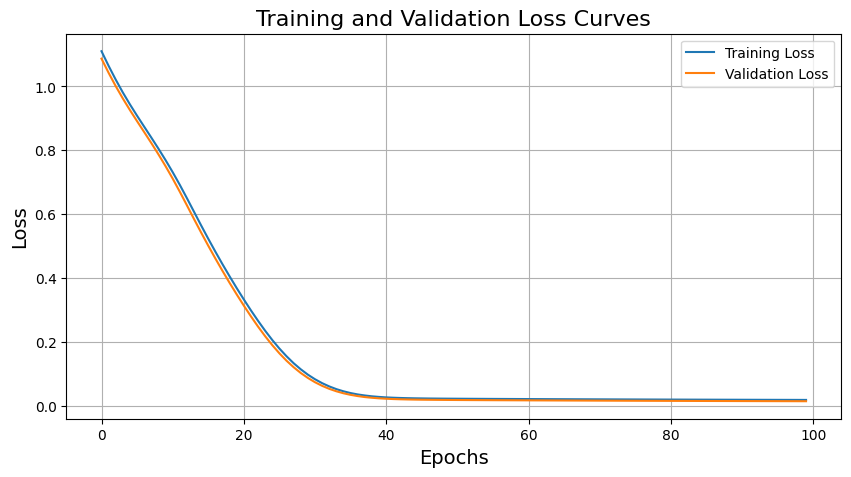

In [39]:
# plot the training and validation loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Curves', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the loss curves:
*   What would you conclude about the overfitting or underfitting capabilities of the model?
*   Is this model adequate to be used? Why?

#### Answers:

1. The model appears to be performing well, with both the training and validation loss decreasing over the course of the training epochs. However, despite the promising results, there's a potential risk of overfitting. The model may have learned this specific dataset effectively but its performance might not generalize well to other data.
2. We cannot conclusively say that the model is effective yet, as we have not evaluated its accuracy on the test data.

## 📈 Results

For our application, we need the model to be both accurate and fast. Here, we will test those qualities.

### Accuracy

#### Loss

Calculate the loss value for the test dataset

In [40]:
tst_loader = pyg_DataLoader(tst_dataset_pyg, batch_size=batch_size, shuffle=False) 
tst_loss = evaluate_epoch(model, tst_loader, device=device)
num_test_sims = len(tst_dataset_pyg)

print('Test loss: ', tst_loss)
print('Number of test scenarios: ', num_test_sims)

Test loss:  0.023005662456154822
Number of test scenarios:  125


### Errors in unnormalized variable

Calculate the error in pressure for all the nodes in all the scenarios. This error matrix should be of shape [Scenarios , Nodes].

Remember that the variables were normalized for training purposes. However, the water utility is interested in the value of the output variable in physical units, in this case, pressure in mH2O. In order to do this, unnormalize the output variable knowing that the maximum and minimum pressures used to normalized the output variable were 59.56 mH2O and 0 mH2O, respectively.

In [94]:
max_pressure = 59.56 #mH2O

num_node = tra_dataset_pyg[0].x.shape[0]
error = np.zeros((num_test_sims, num_node))

estimated_pressures = []
target_pressures = []

def get_pressure():
    model.eval()

    with torch.no_grad():
        for data in tst_dataset_pyg:
            data = data.to(device)
            out = model(data) * max_pressure
            y = data.y * max_pressure
            estimated_pressures.append(out.squeeze())
            target_pressures.append(y.squeeze())


get_pressure()

estimated_pressures = np.stack(estimated_pressures)
target_pressures = np.stack(target_pressures)

error = target_pressures - estimated_pressures

print(f"Error matrix shape: {error.shape}")

Error matrix shape: (125, 37)


#### Error in pressure for all scenarios for one node

Plot the error of one node across test scenarios. 

In [87]:
node_ID = 0
error_node = error[:, node_ID]

(125,)

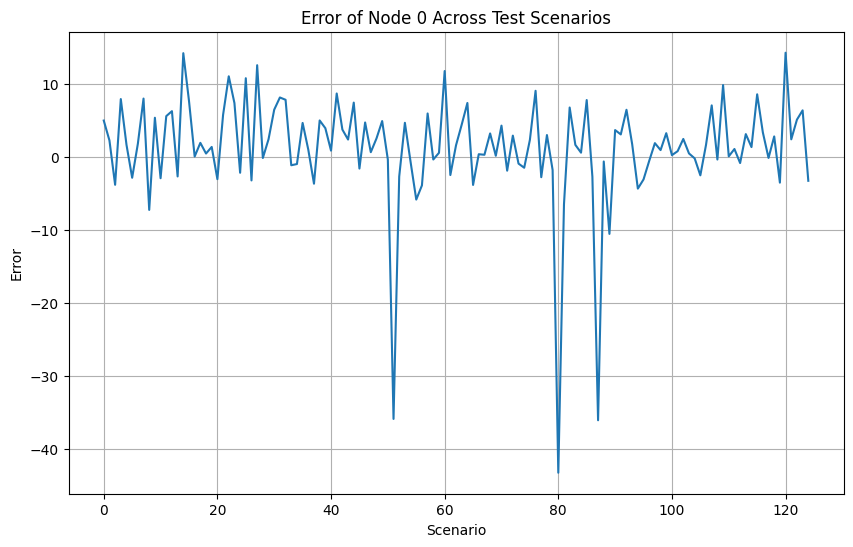

In [95]:
# Plot the error of a single node across test scenarios.
plt.figure(figsize=(10, 6))
plt.plot(error_node)
plt.title('Error of Node 0 Across Test Scenarios')
plt.xlabel('Scenario')
plt.ylabel('Error')
plt.grid(True)
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results accross scenarios:
*   Is the model satisfactorily fitting? 
*   If there are there outliers, do they have any pattern? 
*   Are these errors considerable?



#### Answers:

1. The model shows a reasonable level of fit, as it manages to maintain the error within the range of (-10, 10) in most test scenarios. However, there are several instances where the error rate exceeds this range, indicating that there is room for improvement. While the model is generally fitting, it may not be satisfactory for all cases.
2. A pattern can be observed in the errors, with more significant errors occurring when the model overestimates the pressures. This suggests that the model may be biased towards predicting higher pressures than actually present.
3. Some errors, such as those observed in test scenario 80, are substantial and hence cannot be overlooked. 

#### Error of all nodes in one scenario

Plot the error of all the nodes of one scenario. 

In [96]:
sce_ID = 10
error_sim = error[sce_ID, :]

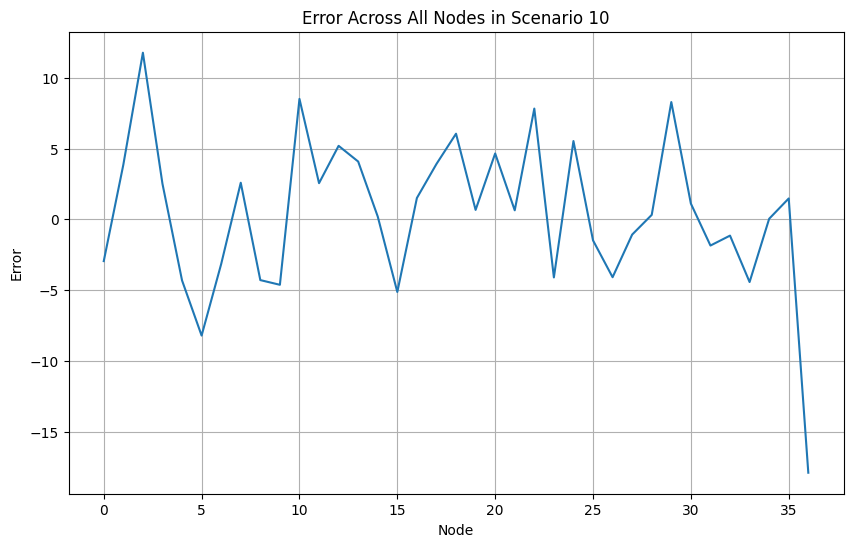

In [180]:
#Plot the error for all the nodes in one single scenario.
nodes = range(len(error_sim))
plt.figure(figsize=(10, 6))
plt.plot(nodes, error_sim)
plt.title('Error Across All Nodes in Scenario 10')
plt.xlabel('Node')
plt.ylabel('Error')
plt.grid(True)
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on this error analysis:
*   How does it compare with the previous error analysis?
*   Is the model over- or under- predicting?
*   Would you recommend the water utility to use this model?
    *   Does your recommendation match with your previous recommendation?

#### Answers:

1. The error level appears to be relatively consistent across different nodes. The majority of nodes yield satisfactory predictions, with errors lying within the (-5, 5) range. However, there remain a number of nodes where the model's predictions deviate significantly, with errors exceeding 10.
2. An observable trend is that there are more nodes with errors greater than 0, indicating that the model tends to under-predict the pressures.
3. Given the current performance of the model, particularly the presence of notable errors and its tendency to under-predict, I wouldn't recommend it. This recommendation aligns with previous assessments.

### Speed

We can calculate the time per scenario that the model takes.

In [98]:
start_time = time.time()
  #Execute the model here for all the simulations in the test case
total_time = time.time() - start_time

data_driven_exec_time_per_sim = total_time/num_test_sims
print(f'Data-driven model took {data_driven_exec_time_per_sim:.5f} seconds for {num_test_sims} scenarios')

Data-driven model took 0.00000 seconds for 125 scenarios


Considering that the original model can take up to 0.04 seconds per scenario, we can estimate the potential gain in speed-up. (Speed-up = original_time/Data-driven_model_time)

In [99]:
original_time_per_sim = 0.04

speed_up = np.round(original_time_per_sim/data_driven_exec_time_per_sim, 2)
print('The data-driven model is', speed_up,'times faster than EPANET per scenario.')

The data-driven model is 185588.67 times faster than EPANET per scenario.


### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results on speed:
*   Which factors or components could make the model faster or slower on its execution?


#### Answers:

The architecture of the model is indeed a crucial factor that influences its speed. Adding more layers and parameters can lead to a slower execution time due to increased computational demands. However, this added complexity has the potential to enhance the model's predictive capacity.
In addition, the batch size used in data loading can also impact the model's speed. Larger batch sizes may increase memory demand and processing time, although they could potentially enhance computational efficiency



## 🥈 Transferability

A practical property of graph neural networks is their independence of the domain in which they are trained on. Therefore, they can be (pre-)trained in one network and be used in another case. Let's explore this property by using the already trained models on another water distribution network. 

This water network comes from the city of Pescara. This network has 71 nodes (68 junctions and 3 reservoirs) and 196 edges (98 pipes).

<center><figure>

  <img src="https://drive.google.com/uc?id=1tpuaoC1Ij3AdAt1zthtft5Lk2vMfq4d3" width=600/>
<figcaption>Figure 3. EPANET results in WDS in Pescara, Italy. 

<sub><sup> Pressure and flows are presented with different color schemes. </sup></sub></figcaption>

</figure></center>

There is already a prepared scenario example from this network. This example has been already normalized. The "y" values were normalized considering a minimum of 0 mH2O and a maximum of 51.75 mH2O. 

Let's load this scenario and use our model to estimate the pressure at all nodes.

In [132]:
with open("PES_example.p", 'rb') as handle:
    pes_data = pickle.load(handle)

Use your model to estimate the pressure for this scenario on this new network.

In [167]:
predictions = []

max_pressure = 51.75

def get_pes(pes_data=pes_data):
    model.eval()
    with torch.no_grad():
        pes_data = pes_data.to(device)
        out = model(pes_data) * max_pressure
        return out.squeeze()

predictions = get_pes(pes_data)

Estimate the difference (in meters) between the actual pressure and the model.

In [176]:
target = (pes_data.y * max_pressure).squeeze()
error = target - predictions

tensor([  3.6168,   1.5587,   3.0898,  10.3363,   2.4016,  11.8152,  20.4640,
         18.0784,   7.1904,   1.7639, -25.2253,  21.1160,  21.2004,  10.9556,
         31.3905,  11.7293,  13.7810,  11.3774,   4.5036,  13.1644,  15.5373,
         17.0595,  22.1548,  36.0880,  33.6437,   8.8564,   9.7070,  10.3216,
          0.0627,   4.8172,   9.3030,  12.2850,  11.3432,  18.3689,   2.2708,
         10.5725,  16.7576,  13.2280,  13.1100,  -9.0165,  -9.7738,   4.7994,
          5.9426,  14.9045,  13.8365,   8.5572,   7.8552,  16.1475,   7.7054,
         17.9743,   8.7157,   1.5494,  18.3563,  16.1797,  16.4967,  14.8786,
         15.1234,   3.7756,  10.9342,  35.7565,  30.1289,  27.9627,  13.1173,
         28.6715,   6.7130,  10.9895,   8.6966,   8.5486,  -5.4784,  -8.1718,
         -0.3568])

Plot the error of all the nodes for this scenario. 

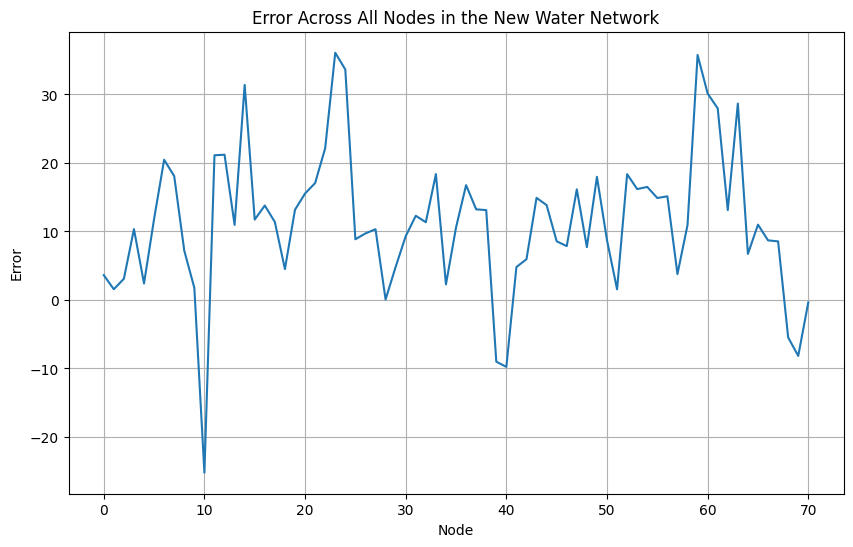

In [179]:
# Plot the error for all the nodes in this new water network.

nodes = range(len(error))
plt.figure(figsize=(10, 6))
plt.plot(nodes, error)
plt.title('Error Across All Nodes in the New Water Network')
plt.xlabel('Node')
plt.ylabel('Error')
plt.grid(True)
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results on transferability:
*   How does this error distribution compare against the error distribution for the previous network?
*   Which factors do you consider influence the performance of the model when it is transferred?
*   How do you consider the model could improve its transfer capability?

#### Answers:

1. The error magnitudes in this new network appear to be substantially higher, with the majority of errors exceeding a value of 10.
2. Factors such as the similarities between the two networks and the complexity of the model's architecture may significantly influence its transfer performance.
3. Enhancing the model's robustness and transfer capabilities could potentially be achieved through techniques such as introducing noise into the training data and employing regularization methods.